In [305]:
import requests
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import pandas as pd

In [306]:
def search(search_type, filters='', fields = [], other_args = {}):
    base_URL = 'https://banks.data.fdic.gov/api/'
    finished = False
    data = []
    
    params = {'limit' : 500}
    params['filters'] = filters
    params['offset'] = 0
    params['fields'] = ','.join(fields)
    
    for key, value in other_args.items():
        params[key] = value
    
    while not finished:
        try:
            r = requests.get(base_URL + search_type, params=params).json()
        except ConnectionError:
            print("Connection error")
            continue
        data.extend(r['data'])
        if len(r['data']) < params['limit']:
            finished = True
        params['offset'] += params['limit']
        
    return [x['data'] for x in data]


In [307]:
numeric_cols = ['ASSET', 'DEP', 'EQ', 'OFFICES']
flag_cols = ['CB', 'CHRTAGNT',  'CFPBFLAG', 'FEDCHRTR',
            'FORM31', 'HCTMULT', 'IBA', 'INSCOML', 'INSSAVE', 'MDI_STATUS_DESC', 'REGAGNT', 'SPECGRP',  'STCHRTR', 'SUBCHAPS',
            'TRACT', 'TRUST']
cols = numeric_cols + flag_cols
variables = flag_cols + ['ROA']

In [308]:
r = search("institutions", 'ACTIVE:1', variables)

In [309]:
frame = pd.DataFrame(r, columns = variables)

In [332]:
data = frame.dropna()

In [333]:
data.head()

,CB,CHRTAGNT,CFPBFLAG,FEDCHRTR,FORM31,HCTMULT,IBA,INSCOML,INSSAVE,MDI_STATUS_DESC,REGAGNT,SPECGRP,STCHRTR,SUBCHAPS,TRACT,TRUST,ROA
0,1,STATE,0,0,0,,0,1,0,NONE,FDIC,4.0,1,0,0,0,0.63
1,1,STATE,0,0,0,,0,1,0,NONE,FDIC,4.0,1,1,0,0,2.74
2,1,STATE,0,0,0,,0,1,0,NONE,FDIC,4.0,1,1,0,0,0.86
3,1,STATE,0,0,0,1,0,1,0,NONE,FDIC,2.0,1,0,0,0,1.44
4,1,OCC,0,1,0,,0,1,0,NONE,OCC,4.0,0,0,1,1,1.28


In [334]:
cdata = data.drop('SPECGRP', axis = 1)
cdata['CHRTAGNT'] = data['CHRTAGNT'].map(dict(STATE=1, OCC=0))
cdata['MDI_STATUS_DESC'] = data['MDI_STATUS_DESC'].map(lambda x: 0 if x == "NONE" else 1)
cdata['REGAGNT'] = data['REGAGNT'].map(lambda x: 0 if x == "FDIC" else 1)
cdata['COMLS'] = data['SPECGRP'].map(lambda x: 1 if x == 4 else 0)
cdata['AGRS'] = data['SPECGRP'].map(lambda x: 1 if x == 2 else 0)
cdata['CONLS'] = data['SPECGRP'].map(lambda x: 1 if x == 6 else 0)
cdata['CCS'] = data['SPECGRP'].map(lambda x: 1 if x == 3 else 0)
cdata['INTLS'] = data['SPECGRP'].map(lambda x: 1 if x == 1 else 0)
cdata['MRLS'] = data['SPECGRP'].map(lambda x: 1 if x == 5 else 0)
cdata['OOBS'] = data['SPECGRP'].map(lambda x: 1 if x == 9 else 0)
cdata['CB'] = data['CB'].map(lambda x: 1 if x == '1' else 0)
cdata['FORM31'] = data['FORM31'].map(lambda x: 1 if x == '1' else 0)
cdata['HCTMULT'] = data['HCTMULT'].map(lambda x: 1 if x == '1' else 0)
cdata['TRACT'] = data['TRACT'].map(lambda x: 1 if x == '1' else 0)
cdata['TRUST'] = data['TRUST'].map(lambda x: 1 if x == '1' else 0)
cdata['SUBCHAPS'] = data['SUBCHAPS'].map(lambda x: 1 if x == '1' else 0)
cdata.head()

,CB,CHRTAGNT,CFPBFLAG,FEDCHRTR,FORM31,HCTMULT,IBA,INSCOML,INSSAVE,MDI_STATUS_DESC,...,TRACT,TRUST,ROA,COMLS,AGRS,CONLS,CCS,INTLS,MRLS,OOBS
0,1,1,0,0,0,0,0,1,0,0,...,0,0,0.63,1,0,0,0,0,0,0
1,1,1,0,0,0,0,0,1,0,0,...,0,0,2.74,1,0,0,0,0,0,0
2,1,1,0,0,0,0,0,1,0,0,...,0,0,0.86,1,0,0,0,0,0,0
3,1,1,0,0,0,1,0,1,0,0,...,0,0,1.44,0,1,0,0,0,0,0
4,1,0,0,1,0,0,0,1,0,0,...,1,1,1.28,1,0,0,0,0,0,0


In [335]:
cdata_shuff =  cdata.sample(frac=1, random_state=42)
inputs = cdata_shuff.drop('ROA', axis = 1)
targets = [0 if x < 1  else 1 for x in cdata_shuff['ROA']]

In [314]:
train, test = train, test = train_test_split(inputs, test_size=0.10, shuffle=False)

train_targets = targets[:len(train)]
test_targets = targets[len(train):]

In [315]:
dtrain = xgb.DMatrix(train, label=train_targets)
dtest = xgb.DMatrix(test, label=test_targets)

In [400]:
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 10
bst = xgb.train(param, dtrain, num_round)

[15:31:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [401]:
preds = bst.predict(dtest)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

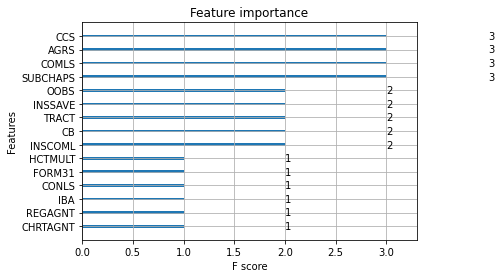

In [402]:
xgb.plot_importance(bst)

In [403]:
test_count = 0

for i in range(len(test)):
    if preds[i] >= .5:
        pred = 1
    else:
        pred = 0
    if pred == test_targets[i]:
        test_count+=1
        
train_preds = bst.predict(dtrain)
train_count = 0
for i in range(len(train)):
    if train_preds[i] >= .5:
        pred = 1
    else:
        pred = 0
    if pred == train_targets[i]:
        train_count+=1
        
print(f'Train accuracy: {train_count / len(train)}\nTest accuracy: {test_count/ len(test)}')

Train accuracy: 0.6797209092955211
Test accuracy: 0.6781376518218624


In [320]:
num_r = search("institutions", 'ACTIVE:1', numeric_cols)

In [375]:
new_frame = pd.DataFrame(num_r, columns = numeric_cols)
num_frame = new_frame.dropna()
new_data= num_frame.copy()
new_data['ASSET'] = pd.to_numeric(num_frame['ASSET'], downcast = "float")
new_data['DEP'] = pd.to_numeric(num_frame['DEP'], downcast = "float")
new_data['EQ'] = pd.to_numeric(num_frame['EQ'], downcast = "float")
new_data['OFFICES'] = pd.to_numeric(num_frame['OFFICES'], downcast = "float")

In [322]:
scaler = preprocessing.StandardScaler()
scaled_num_data = scaler.fit_transform(new_data)
scaled_num_data = pd.DataFrame(scaled_num_data, columns=numeric_cols)

In [389]:
join_data = scaled_num_data.join(cdata)

In [390]:
new_cdata = join_data.dropna()

In [391]:
new_cdata_shuff =  new_cdata.sample(frac=1, random_state=87)
new_inputs = new_cdata_shuff.drop('ROA', axis = 1)
new_targets = [0 if x < 1 else 1 for x in new_cdata_shuff['ROA']]

In [392]:
new_train, new_test = train, test = train_test_split(new_inputs, test_size=0.10, shuffle=False)

new_train_targets = new_targets[:len(new_train)]
new_test_targets = new_targets[len(new_train):]

In [393]:
new_dtrain = xgb.DMatrix(new_train, label=new_train_targets)
new_dtest = xgb.DMatrix(new_test, label=new_test_targets)

In [394]:
param = {'max_depth': 2, 'eta':1, 'objective':'binary:logistic' }
num_round = 8
new_bst = xgb.train(param, new_dtrain, num_round)

[15:07:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [395]:
new_preds = new_bst.predict(new_dtest)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

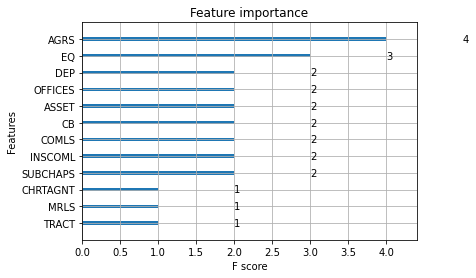

In [396]:
xgb.plot_importance(new_bst)

In [397]:
test_count = 0
for i in range(len(new_test)):
    if new_preds[i] >= .5:
        pred = 1
    else:
        pred = 0
    if pred == new_test_targets[i]:
        test_count+=1
        
new_train_preds = new_bst.predict(new_dtrain)
train_count = 0
for i in range(len(new_train)):
    if new_train_preds[i] >= .5:
        pred = 1
    else:
        pred = 0
    if pred == new_train_targets[i]:
        train_count+=1
        
print(f'Train accuracy: {train_count / len(new_train)}\nTest accuracy: {test_count/ len(new_test)}')

Train accuracy: 0.700877785280216
Test accuracy: 0.7004048582995951
